# Train without normalize

This notebook will use the KuHar view (balanced_motionsense_equivalent_view) and will:

1. Apply DFT over dataset windows
2. Train three times with RF, SVM and KNN, and take the average accuracy and f1-score
3. Plot UMAP and T-SNE

In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from librep.datasets.har.loaders import KuHar_BalancedView20HzMotionSenseEquivalent
from librep.datasets.multimodal import TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-11-25 17:52:09.440421: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-25 17:52:09.440444: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Load KuHar, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = KuHar_BalancedView20HzMotionSenseEquivalent("../../data/views/KuHar/balanced_20Hz_motionsense_equivalent-v1", 
                              download=False)
train_val, test = loader.load(concat_train_validation=True, label="standard activity code")
train_val

PandasMultiModalDataset: samples=3114, features=360, no. window=6, label_columns='standard activity code'

In [4]:
train_val.window_names, train_val.window_slices

(['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z'],
 [(0, 60), (60, 120), (120, 180), (180, 240), (240, 300), (300, 360)])

In [5]:
# Checking the whole data...
train_val[:][0]

array([[ -1.04282825,   7.06961015,   3.45567162, ...,   0.50890319,
         -0.11305444,  -0.38018973],
       [ -2.43790048,  -2.62844861,  -2.16686063, ...,  -0.09413675,
         -0.23829967,   0.3772596 ],
       [ -0.66433712,   0.48346468,   3.09023849, ...,   0.28845053,
          0.11892508,   0.28859494],
       ...,
       [  3.92724394,  19.31137994,   0.4036726 , ...,   0.92610044,
          1.03635366,  -0.09064377],
       [ -7.20889409, -11.73424672,  13.67743163, ...,  -0.13913523,
          0.74242743,   0.76542017],
       [ -1.30519969,   0.77625489,  -2.01040912, ...,   0.53948006,
          1.16119165,  -0.4627136 ]])

In [6]:
train_val[0][0].shape

(360,)

In [7]:
# Create the objects
fft_transform = FFT(centered=True)

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform], new_window_name_prefix="fft."
)

In [8]:
# Transform it and generate a new dataset!
train_val_fft = transformer(train_val)
test_fft = transformer(test)

In [9]:
# Checking the whole data...
train_val_fft[:][0]

array([[ 0.91733879,  0.29440329,  1.23462554, ...,  0.1129337 ,
         0.26412922,  0.13996405],
       [ 0.65233708,  1.97729668,  2.15721029, ...,  0.06154191,
         0.10466632,  0.31628686],
       [ 3.45508609,  4.17256855,  4.84083478, ...,  0.23428507,
         0.1365104 ,  0.23990389],
       ...,
       [ 6.79381019,  3.57460369,  4.11276002, ...,  0.21081426,
         0.19608279,  0.62261425],
       [10.5895549 ,  2.52004627,  2.10073354, ...,  0.35299741,
         1.14334167,  0.4671062 ],
       [ 4.11236397,  2.83530961,  0.89885128, ...,  0.97035186,
         0.66428777,  0.21100239]])

## Plot UMAP

In [10]:
def plot(df, figsize: tuple = (5, 5), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label, s=3)
    ax.legend()
    plt.title(title)
    plt.show()

In [11]:
labels = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run"
}
print(labels)

{0: 'sit', 1: 'stand', 2: 'walk', 3: 'stair up', 4: 'stair down', 5: 'run'}


### UMAP

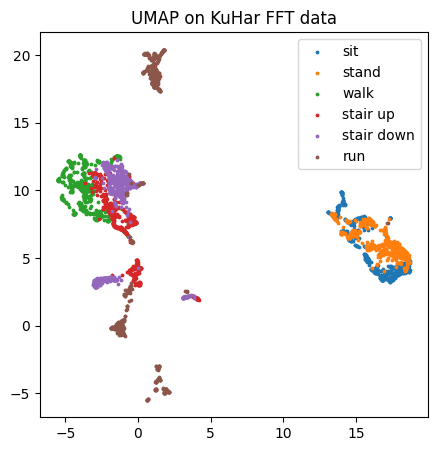

In [12]:
model = UMAP(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val_fft[:][0]), columns=["x", "y"])
result["label"] = train_val_fft[:][1]
plot(result, title="UMAP on KuHar FFT data", labels = labels)

In [13]:
result

,x,y,label
0,-1.159364,11.761194,4
1,-1.219785,11.785466,4
2,-2.014207,10.744961,4
3,-1.098313,11.323413,4
4,3.830194,2.162078,4
...,...,...,...
3109,0.432509,20.072577,5
3110,1.095843,19.007643,5
3111,0.972210,18.938116,5
3112,0.418664,20.057756,5


In [14]:
corners = np.array([
    [-7, -7],
    [-7, 25],
    [25, -7],  
    [25, 25]
])

# corners = np.array([
#     [-5, -10],  # 1
#     [-7, 6],  # 7
#     [2, -8],  # 2
#     [12, 4],  # 0
# ])

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 50)
    for x in np.linspace(0, 1, 50)
])

In [15]:
test_pts[:,0].shape

(2500,)

In [16]:
np.zeros(10000, dtype=int)

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
new_df = pd.DataFrame()
new_df['x'] = test_pts[:,0]
new_df['y'] = test_pts[:,1]

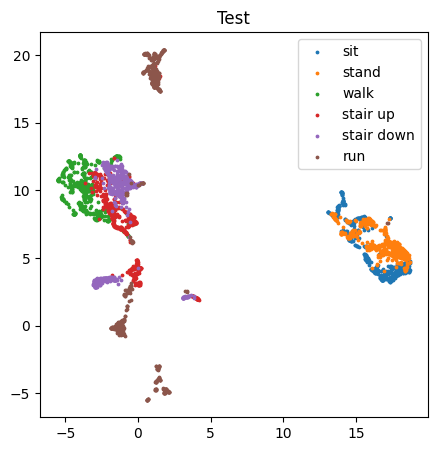

In [18]:
new_df2 = pd.concat([result, new_df], axis=0)

plot(new_df2, title="Test", labels = labels)

In [19]:
rf = RandomForestClassifier()
rf.fit(train_val_fft[:][0], train_val_fft[:][1])

RandomForestClassifier()

In [20]:
test_pts2 = model.inverse_transform(test_pts)
pred = rf.predict(test_pts2)

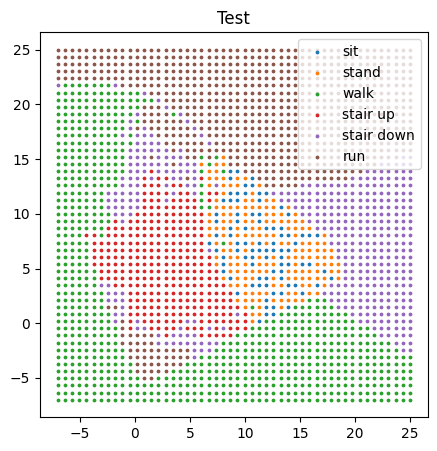

In [21]:
new_df['label'] = pred

new_df2 = pd.concat([result, new_df], axis=0)

plot(new_df, title="Test", labels = labels)